In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [2]:
path = Path('data/mnist_png/')

In [3]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, test='test',ds_tfms=tfms, size=26)

In [4]:
def create_head_sigmoid(nf:int, nc:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5):
    """Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes.
    :param ps: dropout, can be a single float or a list for each layer."""
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps)==1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.Sigmoid()] * (len(lin_ftrs)-2) + [None]
    layers = [AdaptiveConcatPool2d(), Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],ps,actns):
        layers += bn_drop_lin(ni,no,True,p,actn)
    return nn.Sequential(*layers)

In [4]:
head = create_head(1024,10,lin_ftrs=[128])

In [5]:
learner = create_cnn(data, models.resnet18, custom_head=head, metrics=[accuracy])

In [4]:
learner = create_cnn(data, models.resnet18, metrics=[accuracy])

In [5]:
learner.fit_one_cycle(1,1e-3)

Total time: 03:52
epoch  train_loss  valid_loss  accuracy
1      0.335584    0.138601    0.955066  (03:52)



In [6]:
learner.save('stage-test')

In [7]:
learner.load('stage-test')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (54051 items)
[Category 8, Category 8, Category 8, Category 8, Category 8]...
Path: .
x: ImageItemList (54051 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: data/mnist_png;
Valid: LabelList
y: CategoryList (8991 items)
[Category 8, Category 8, Category 8, Category 8, Category 8]...
Path: .
x: ImageItemList (8991 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: data/mnist_png;
Test: LabelList
y: CategoryList (11 items)
[Category 8, Category 8, Category 8, Category 8, Category 8]...
Path: .
x: ImageItemList (11 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: data/mnist_png, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum

In [10]:
classes = list(range(9))

In [13]:
data2 = ImageDataBunch.single_from_classes(path, classes, tfms=tfms, size=26)

In [14]:
learner = create_cnn(data2, models.resnet18).load('stage-test')

In [15]:
learner

IndexError: list index out of range

In [8]:
learner.unfreeze()

In [9]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


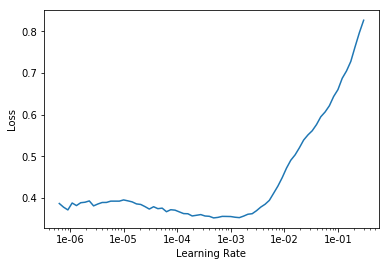

In [10]:
learner.recorder.plot()

In [11]:
learner.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

Total time: 00:56
epoch  train_loss  valid_loss  accuracy
1      0.175250    0.046171    0.986987  (00:28)
2      0.135289    0.034982    0.989990  (00:27)



In [14]:
learner.save('stage-1-50')

In [10]:
learner.load('stage-1-50')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (54051 items)
[Category 8, Category 8, Category 8, Category 8, Category 8]...
Path: .
x: ImageItemList (54051 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: data/mnist_png;
Valid: LabelList
y: CategoryList (8991 items)
[Category 8, Category 8, Category 8, Category 8, Category 8]...
Path: .
x: ImageItemList (8991 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: data/mnist_png;
Test: LabelList
y: CategoryList (14 items)
[Category 8, Category 8, Category 8, Category 8, Category 8]...
Path: .
x: ImageItemList (14 items)
[Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28), Image (3, 28, 28)]...
Path: data/mnist_png, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum

In [21]:
interp = ClassificationInterpretation.from_learner(learner)

In [22]:
interp.most_confused(min_val=2)

[('5', '3', 8),
 ('8', '4', 5),
 ('8', '2', 5),
 ('7', '2', 5),
 ('3', '8', 5),
 ('1', '7', 4),
 ('5', '8', 4),
 ('6', '0', 4),
 ('3', '7', 4),
 ('8', '0', 3),
 ('8', '3', 3),
 ('0', '6', 3),
 ('7', '1', 3),
 ('7', '4', 3),
 ('6', '5', 3),
 ('2', '7', 3),
 ('2', '3', 3),
 ('3', '5', 3),
 ('3', '2', 3)]

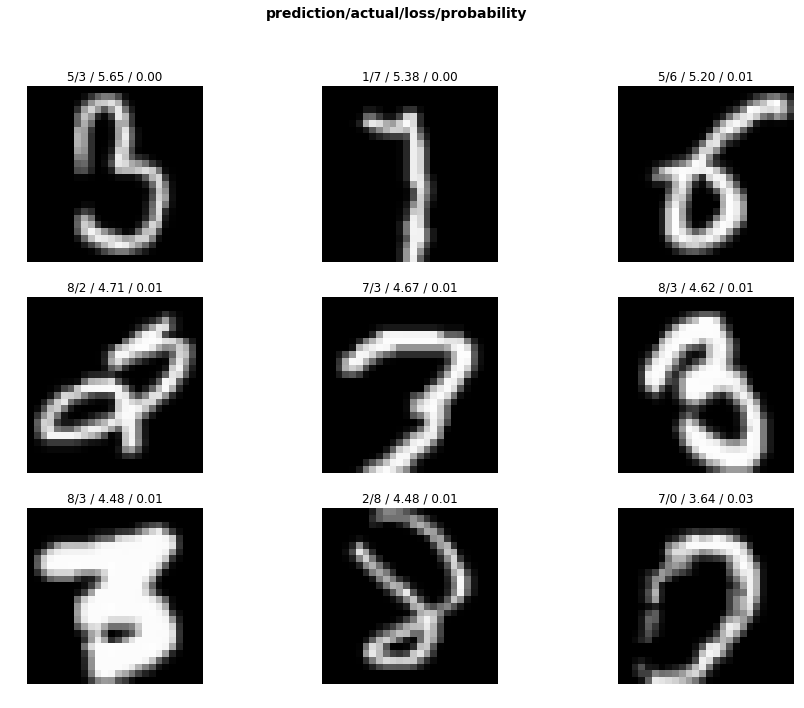

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

In [25]:
flatten_model(learner.model)[-3]

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

### Deep hash

In [29]:
ds_type

NameError: name 'ds_type' is not defined

In [54]:
test = learner.callbacks[0].outputs[0] > 0

In [59]:
sum(test[0] == test[1]).float()/48

tensor(0.7500, device='cuda:0')

In [55]:
test

tensor([[0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
         1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
         0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0],
        [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
         1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
         1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0],
        [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
         1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
         0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1],
        [0, 0, 1, 1, 0

In [34]:
learner.get_preds(ds_type=DatasetType.Test)

[tensor([[0.6914, 0.0219, 0.0219, 0.0105, 0.0479, 0.1087, 0.0117, 0.0611, 0.0152,
          0.0097],
         [0.1214, 0.0048, 0.0019, 0.0043, 0.0209, 0.8295, 0.0032, 0.0098, 0.0013,
          0.0030],
         [0.6326, 0.0312, 0.0100, 0.0119, 0.1516, 0.0811, 0.0053, 0.0615, 0.0063,
          0.0083],
         [0.5614, 0.0133, 0.0071, 0.0192, 0.0542, 0.3059, 0.0069, 0.0181, 0.0057,
          0.0083],
         [0.8902, 0.0094, 0.0051, 0.0105, 0.0355, 0.0138, 0.0046, 0.0194, 0.0069,
          0.0048],
         [0.0024, 0.0052, 0.0043, 0.0030, 0.8984, 0.0736, 0.0010, 0.0063, 0.0027,
          0.0032],
         [0.9702, 0.0037, 0.0006, 0.0020, 0.0043, 0.0032, 0.0020, 0.0093, 0.0033,
          0.0013],
         [0.0482, 0.0656, 0.0057, 0.0188, 0.7881, 0.0327, 0.0032, 0.0246, 0.0045,
          0.0088],
         [0.0357, 0.0040, 0.0124, 0.3138, 0.5677, 0.0222, 0.0019, 0.0271, 0.0075,
          0.0077],
         [0.2477, 0.0814, 0.0112, 0.0814, 0.0320, 0.1803, 0.0811, 0.2366, 0.0408,
         

In [11]:
from fastai.callbacks import *

In [12]:
class StoreHook2(Callback):
    def __init__(self, module):
        super().__init__()
        self.custom_hook = hook_output(module)
        self.outputs = []
        
    def on_batch_end(self, train, **kwargs): 
        if (not train): self.outputs.append(self.custom_hook.stored)

In [13]:
nn_module = learner.model[-1][-3]
learner.callbacks = [ StoreHook2(nn_module) ]

In [14]:
nn_module

BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [14]:
import fastai
fastai.defaults.device = torch.device('cpu')

In [15]:
for i in (path/'test').iterdir():
    print(i)

data/mnist_png/test/78.png
data/mnist_png/test/92.png
data/mnist_png/test/2.png
data/mnist_png/test/58.png
data/mnist_png/test/100.png
data/mnist_png/test/12.png
data/mnist_png/test/9.png
data/mnist_png/test/20.png
data/mnist_png/test/5.png
data/mnist_png/test/73.png
data/mnist_png/test/14.png
data/mnist_png/test/16.png
data/mnist_png/test/62.png
data/mnist_png/test/7.png


In [23]:
imgs = []
for i in (path/'test').iterdir():
    learner.predict(open_image(i))

In [16]:
classes = ['0', '1', '2', '3','4', '5','6','7','8', '9']

In [38]:
# data2 = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [17]:
len(learner.callbacks[0].outputs)

11

In [86]:
for i in learner.callbacks[0].outputs:
    i = (i>0)

In [24]:
for i in range(len(learner.callbacks[0].outputs)):
    learner.callbacks[0].outputs[i] = learner.callbacks[0].outputs[i] > 0

In [18]:
learner.callbacks[0].outputs

[tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
          1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
          1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
          0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
          0, 0, 1, 0, 1, 0, 0, 1]], device='cuda:0', dtype=torch.uint8),
 tensor([[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
          1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
          1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
          0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
          0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
          0, 0, 1, 1, 1, 0, 0, 1]], device='cuda:0', dtype=torch.uint8),
 tensor([[0, 0, 1, 1, 1, 0, 0, 0, 

In [17]:
def similarity(ten1, ten2):
    return sum(ten1 == ten2).float()/len(ten1)

In [130]:
test = learner.get_preds(ds_type=DatasetType.Test)

In [131]:
learner.data.c

9

In [132]:
test = [tensor >= 0 for tensor in learner.callbacks[0].outputs[0]]

In [86]:
learner.callbacks[0].outputs[0].shape

torch.Size([1, 512])

In [22]:
learner.callbacks[0].outputs = []

In [92]:
sum(learner.callbacks[0].outputs[1][0] == learner.callbacks[0].outputs[2][0])

tensor(37, device='cuda:0', dtype=torch.uint8)

In [21]:
sum(learner.callbacks[0].outputs[1] == learner.callbacks[0].outputs[2])

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0', dtype=torch.uint8)

In [25]:
def similarity(ten1, ten2):
    return (ten1 == ten2).sum().float()/len(ten1)

In [46]:
learner.callbacks[0].outputs[0][1]

tensor([-0.2829, -0.0741,  0.1167,  0.9211,  0.2735, -0.0583, -0.0563, -0.1541,
        -0.6846,  0.1998, -0.5723,  0.3090, -0.7078, -0.7726, -0.0956, -0.2914,
        -0.6678, -0.5235, -0.2385, -0.2636,  0.5919, -0.5963,  0.6794, -0.5786,
        -0.0231,  0.1369,  1.4616, -0.3807, -0.4913, -0.4185,  0.1308,  0.1463,
        -0.0078,  0.9327, -0.4248, -0.3968, -0.1483, -0.1712,  0.5836, -0.5731,
        -0.1895,  1.1254, -0.5106,  0.2287,  1.8980,  0.3347,  0.9621, -0.3747],
       device='cuda:0')

In [23]:
test = learner.callbacks[0].outputs[0] == learner.callbacks[0].outputs[1]

In [29]:
len(test[0])

512

In [36]:
test[0].sum().float()/len(test[0])

tensor(0.8242, device='cuda:0')

In [20]:
similarity(learner.callbacks[0].outputs[1][0], learner.callbacks[0].outputs[2][0])

tensor(0.4766, device='cuda:0')

In [26]:
for i in range(1,len(learner.callbacks[0].outputs)):
    print(similarity(learner.callbacks[0].outputs[i-1][0], learner.callbacks[0].outputs[i][0]))

tensor(0.8281, device='cuda:0')
tensor(0.7422, device='cuda:0')
tensor(0.5391, device='cuda:0')
tensor(0.5469, device='cuda:0')
tensor(0.8203, device='cuda:0')
tensor(0.5938, device='cuda:0')
tensor(0.6484, device='cuda:0')
tensor(0.6719, device='cuda:0')
tensor(0.6953, device='cuda:0')
tensor(0.4766, device='cuda:0')


## 512 without custom head

tensor(0.8242, device='cuda:0')
tensor(0.6855, device='cuda:0')
tensor(0.5410, device='cuda:0')
tensor(0.6289, device='cuda:0')
tensor(0.8281, device='cuda:0')
tensor(0.6484, device='cuda:0')
tensor(0.6543, device='cuda:0')
tensor(0.6602, device='cuda:0')
tensor(0.6816, device='cuda:0')
tensor(0.6465, device='cuda:0')

## _______________

In [77]:
last_layer = flatten_model(learner.model)[-4]
hook = hook_output(last_layer)
learner.model.eval()
n_valid = len(data.valid_ds.ds.y)
for i in range(n_valid):
    img,label = data.valid_dl.dl.dataset[i]
    img = apply_tfms(learner.data.valid_ds.tfms, img, **learner.data.valid_ds.kwargs)
    ds = TensorDataset(img.data[None], torch.zeros(1))
    dl = DeviceDataLoader.create(ds, bs=1, shuffle=False, device=learner.data.device, tfms=learner.data.valid_dl.tfms,
                                     num_workers=0)
    pred = learner.model(dl.one_batch()[0])
    if i % 1000 == 0:
        print(f'{i/n_valid*100:.2f}% ready')
    if i == 0 :
        acts = hook.stored 
    else : acts = torch.cat((acts,hook.stored), dim=0) 

0.00% ready
10.00% ready
20.00% ready
30.00% ready
40.00% ready
50.00% ready
60.00% ready
70.00% ready
80.00% ready
90.00% ready


In [ ]:
##############

In [10]:
path

PosixPath('data/mnist_png')

In [12]:
img = open_image(path/'train'/'0'/'1.png')
img


In [ ]:
#############

In [78]:
n_valid

10000

In [79]:
acts

tensor([[0.9208, 0.1967, 0.1615,  ..., 0.2055, 0.1965, 0.2695],
        [0.7690, 0.3116, 0.2350,  ..., 0.4939, 0.4071, 0.5612],
        [0.8755, 0.3027, 0.4429,  ..., 0.2833, 0.7314, 0.6014],
        ...,
        [0.9912, 0.4374, 0.5070,  ..., 0.6587, 0.9984, 0.0100],
        [0.9916, 0.5531, 0.3060,  ..., 0.4047, 0.9961, 0.0250],
        [0.9800, 0.3706, 0.3905,  ..., 0.5015, 0.9870, 0.0445]],
       device='cuda:0')

In [82]:
acts.min(), acts.max()

(tensor(0.0000, device='cuda:0'), tensor(1.0000, device='cuda:0'))

In [97]:
x,y = next(iter(learner.data.dl()))

In [ ]:
learner.data.

In [101]:
x[0].shape

torch.Size([3, 26, 26])

In [103]:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [104]:
learner.model(x)

tensor([[ 5.2568,  0.0126, -2.1019, -0.0506, -1.4299, -2.9875, -1.1473, -1.0635,
         -0.9801, -1.0286],
        [ 6.3660, -2.2681, -2.5187, -0.4977,  0.0322, -1.4064, -2.0282, -2.0755,
         -0.3303, -0.2486],
        [ 3.2465, -3.1359, -2.6956, -0.8180, -0.7339, -1.9351, -2.7494, -1.1656,
          0.2773,  3.1165],
        [ 6.3131, -1.8616, -2.2819, -0.9425, -0.4056, -0.9520, -1.4989, -2.1725,
         -0.1248, -0.5101],
        [ 6.3528, -2.5184, -2.4061, -1.1179, -0.4904, -1.0596, -1.6930, -1.7939,
         -0.3682, -0.3093],
        [ 5.6839, -2.0560, -2.1909, -0.6993,  0.2471, -1.5920, -1.9343, -1.0543,
         -1.0458, -0.2415],
        [ 6.2398, -2.8143, -2.3845, -0.7403,  0.0163, -1.1798, -2.4997, -1.7223,
         -0.5685,  0.2872],
        [ 6.3109, -2.7426, -2.4975, -0.1551,  0.2293, -0.4423, -2.0913, -1.7176,
         -0.7380, -0.5249],
        [ 6.3841, -1.9306, -2.0407, -0.8774,  0.7967, -0.9898, -1.5876, -1.6695,
         -0.5279, -0.7433],
        [ 6.0287, -